In [23]:
import polars as pl
# 列表示を省略しない
pl.Config.set_tbl_cols(-1)
# 行の表示を省略しない
pl.Config.set_tbl_rows(-1)

polars.config.Config

# １章 ウェブの注文数を分析する１０本ノック



### ノック１：データを読み込んでみよう

In [24]:
customer_master = pl.read_csv("customer_master.csv")
customer_master.head()

customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref
str,str,str,str,str,str,i64,str,str
"""IK152942""","""平田 裕次郎""","""2019-01-01 00:…","""ひらた ゆうじろう""","""hirata_yuujiro…","""M""",29,"""1990/6/10""","""石川県"""
"""TS808488""","""田村 詩織""","""2019-01-01 01:…","""たむら しおり""","""tamura_shiori@…","""F""",33,"""1986/5/20""","""東京都"""
"""AS834628""","""久野 由樹""","""2019-01-01 02:…","""ひさの ゆき""","""hisano_yuki@ex…","""F""",63,"""1956/1/2""","""茨城県"""
"""AS345469""","""鶴岡 薫""","""2019-01-01 04:…","""つるおか かおる""","""tsuruoka_kaoru…","""M""",74,"""1945/3/25""","""東京都"""
"""GD892565""","""大内 高史""","""2019-01-01 04:…","""おおうち たかし""","""oouchi_takashi…","""M""",54,"""1965/8/5""","""千葉県"""


In [25]:
item_master = pl.read_csv("item_master.csv")
item_master.head()

item_id,item_name,item_price
str,str,i64
"""S001""","""PC-A""",50000
"""S002""","""PC-B""",85000
"""S003""","""PC-C""",120000
"""S004""","""PC-D""",180000
"""S005""","""PC-E""",210000


In [26]:
transaction_1 = pl.read_csv("transaction_1.csv")
transaction_1.head()

transaction_id,price,payment_date,customer_id
str,i64,str,str
"""T0000000113""",210000,"""2019-02-01 01:…","""PL563502"""
"""T0000000114""",50000,"""2019-02-01 01:…","""HD678019"""
"""T0000000115""",120000,"""2019-02-01 02:…","""HD298120"""
"""T0000000116""",210000,"""2019-02-01 02:…","""IK452215"""
"""T0000000117""",170000,"""2019-02-01 04:…","""PL542865"""


In [27]:
transaction_detail_1 = pl.read_csv("transaction_detail_1.csv")
transaction_detail_1.head()

detail_id,transaction_id,item_id,quantity
i64,str,str,i64
0,"""T0000000113""","""S005""",1
1,"""T0000000114""","""S001""",1
2,"""T0000000115""","""S003""",1
3,"""T0000000116""","""S005""",1
4,"""T0000000117""","""S002""",2


### ノック２：データを結合(ユニオン)してみよう

In [28]:
transaction_2 = pl.read_csv("transaction_2.csv")
transaction = pl.concat(items = [transaction_1, transaction_2])
transaction.head()

transaction_id,price,payment_date,customer_id
str,i64,str,str
"""T0000000113""",210000,"""2019-02-01 01:…","""PL563502"""
"""T0000000114""",50000,"""2019-02-01 01:…","""HD678019"""
"""T0000000115""",120000,"""2019-02-01 02:…","""HD298120"""
"""T0000000116""",210000,"""2019-02-01 02:…","""IK452215"""
"""T0000000117""",170000,"""2019-02-01 04:…","""PL542865"""


In [29]:
print( len(transaction_1) )
print( len(transaction_2) )
print( len(transaction) )

5000
1786
6786


In [30]:
transaction_detail_2 = pl.read_csv("transaction_detail_2.csv")
transaction_detail = pl.concat(items = [transaction_detail_1, transaction_detail_2])
transaction_detail.head()

detail_id,transaction_id,item_id,quantity
i64,str,str,i64
0,"""T0000000113""","""S005""",1
1,"""T0000000114""","""S001""",1
2,"""T0000000115""","""S003""",1
3,"""T0000000116""","""S005""",1
4,"""T0000000117""","""S002""",2


In [31]:
print( len(transaction_detail_1) )
print( len(transaction_detail_2) )
print( len(transaction_detail) )

5000
2144
7144


### ノック３：売上データ同士を結合(ジョイン)してみよう

In [32]:
join_data = transaction_detail.join(other = transaction[["transaction_id", "payment_date", "customer_id"]], on = "transaction_id", how = "left")
join_data.head()

detail_id,transaction_id,item_id,quantity,payment_date,customer_id
i64,str,str,i64,str,str
0,"""T0000000113""","""S005""",1,"""2019-02-01 01:…","""PL563502"""
1,"""T0000000114""","""S001""",1,"""2019-02-01 01:…","""HD678019"""
2,"""T0000000115""","""S003""",1,"""2019-02-01 02:…","""HD298120"""
3,"""T0000000116""","""S005""",1,"""2019-02-01 02:…","""IK452215"""
4,"""T0000000117""","""S002""",2,"""2019-02-01 04:…","""PL542865"""


In [33]:
print( len(transaction_detail) )
print( len(transaction) )
print( len(join_data) )

7144
6786
7144


### ノック４：マスタデータを結合(ジョイン)してみよう

In [34]:
join_data = (
    join_data
    .join(other = customer_master, on = "customer_id", how = "left")
    .join(other = item_master, on = "item_id", how = "left")
)
join_data.head()

detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref,item_name,item_price
i64,str,str,i64,str,str,str,str,str,str,str,i64,str,str,str,i64
0,"""T0000000113""","""S005""",1,"""2019-02-01 01:…","""PL563502""","""井本 芳正""","""2019-01-07 14:…","""いもと よしまさ""","""imoto_yoshimas…","""M""",30,"""1989/7/15""","""熊本県""","""PC-E""",210000
1,"""T0000000114""","""S001""",1,"""2019-02-01 01:…","""HD678019""","""三船 六郎""","""2019-01-27 18:…","""みふね ろくろう""","""mifune_rokurou…","""M""",73,"""1945/11/29""","""京都府""","""PC-A""",50000
2,"""T0000000115""","""S003""",1,"""2019-02-01 02:…","""HD298120""","""山根 小雁""","""2019-01-11 08:…","""やまね こがん""","""yamane_kogan@e…","""M""",42,"""1977/5/17""","""茨城県""","""PC-C""",120000
3,"""T0000000116""","""S005""",1,"""2019-02-01 02:…","""IK452215""","""池田 菜摘""","""2019-01-10 05:…","""いけだ なつみ""","""ikeda_natsumi@…","""F""",47,"""1972/3/17""","""兵庫県""","""PC-E""",210000
4,"""T0000000117""","""S002""",2,"""2019-02-01 04:…","""PL542865""","""栗田 憲一""","""2019-01-25 06:…","""くりた けんいち""","""kurita_kenichi…","""M""",74,"""1944/12/17""","""長崎県""","""PC-B""",85000


### ノック5：必要なデータ列を作ろう

In [35]:
join_data = (
    join_data.with_columns([
        (join_data["quantity"] * join_data["item_price"]).alias("price")
    ])
)
join_data[["quantity", "item_price", "price"]].head()

quantity,item_price,price
i64,i64,i64
1,210000,210000
1,50000,50000
1,120000,120000
1,210000,210000
2,85000,170000


### ノック6：データ検算をしよう

In [36]:
print( join_data["price"].sum() )
print( transaction["price"].sum() )

971135000
971135000


In [37]:
join_data["price"].sum() == transaction["price"].sum()

True

### ノック7：各種統計量を把握しよう

In [38]:
join_data.null_count()

detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref,item_name,item_price,price
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
import polars.selectors as cs
join_data.select(cs.numeric()).describe()

describe,detail_id,quantity,age,item_price,price
str,f64,f64,f64,f64,f64
"""count""",7144.0,7144.0,7144.0,7144.0,7144.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",3571.5,1.199888,50.265677,121698.628219,135937.150056
"""std""",2062.439494,0.513647,17.190314,64571.31183,68511.453297
"""min""",0.0,1.0,20.0,50000.0,50000.0
"""25%""",1786.0,1.0,36.0,50000.0,85000.0
"""50%""",3572.0,1.0,50.0,120000.0,120000.0
"""75%""",5358.0,1.0,65.0,210000.0,210000.0
"""max""",7143.0,4.0,80.0,210000.0,420000.0


In [40]:
print( join_data["payment_date"].min() )
print( join_data["payment_date"].max() )

2019-02-01 01:36:57
2019-07-31 23:41:38


### ノック8：月別でデータを集計してみよう

In [41]:
join_data.dtypes

[Int64,
 Utf8,
 Utf8,
 Int64,
 Utf8,
 Utf8,
 Utf8,
 Utf8,
 Utf8,
 Utf8,
 Utf8,
 Int64,
 Utf8,
 Utf8,
 Utf8,
 Int64,
 Int64]

In [42]:
join_data = (
    join_data.with_columns(
        join_data["payment_date"].str.to_datetime()
        .alias("payment_date")
    )
)
join_data = (
    join_data.with_columns([
        join_data["payment_date"].dt.strftime("%Y/%m")
    .alias("payment_month")
    ])
)
join_data[["payment_date", "payment_month"]].head()

payment_date,payment_month
datetime[μs],str
2019-02-01 01:36:57,"""2019/02"""
2019-02-01 01:37:23,"""2019/02"""
2019-02-01 02:34:19,"""2019/02"""
2019-02-01 02:47:23,"""2019/02"""
2019-02-01 04:33:46,"""2019/02"""


In [47]:
join_data.group_by(by = "payment_month").agg( pl.col("price").sum() )

payment_month,price
str,i64
"""2019/03""",160370000
"""2019/04""",160510000
"""2019/07""",170620000
"""2019/05""",155420000
"""2019/06""",164030000
"""2019/02""",160185000


### ノック9：月別、商品別でデータを集計してみよう

In [49]:
(
    join_data
    .group_by(by = ["payment_month", "item_name"]).agg( pl.sum("price"), pl.sum("quantity") )
    .sort(by = ["payment_month", "item_name"])
)

payment_month,item_name,price,quantity
str,str,i64,i64
"""2019/02""","""PC-A""",24150000,483
"""2019/02""","""PC-B""",25245000,297
"""2019/02""","""PC-C""",19800000,165
"""2019/02""","""PC-D""",31140000,173
"""2019/02""","""PC-E""",59850000,285
"""2019/03""","""PC-A""",26000000,520
"""2019/03""","""PC-B""",25500000,300
"""2019/03""","""PC-C""",19080000,159
"""2019/03""","""PC-D""",25740000,143


In [51]:
(
    join_data
    .pivot(index = "item_name",
           columns = "payment_month",
           values = ["price", "quantity"],
           aggregate_function = "sum",
           sort_columns = True)
           .sort("item_name")
)

item_name,price_payment_month_2019/02,price_payment_month_2019/03,price_payment_month_2019/04,price_payment_month_2019/05,price_payment_month_2019/06,price_payment_month_2019/07,quantity_payment_month_2019/02,quantity_payment_month_2019/03,quantity_payment_month_2019/04,quantity_payment_month_2019/05,quantity_payment_month_2019/06,quantity_payment_month_2019/07
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""PC-A""",24150000,26000000,25900000,24850000,26000000,25250000,483,520,518,497,520,505
"""PC-B""",25245000,25500000,23460000,25330000,23970000,28220000,297,300,276,298,282,332
"""PC-C""",19800000,19080000,21960000,20520000,21840000,19440000,165,159,183,171,182,162
"""PC-D""",31140000,25740000,24300000,25920000,28800000,26100000,173,143,135,144,160,145
"""PC-E""",59850000,64050000,64890000,58800000,63420000,71610000,285,305,309,280,302,341


### ノック10：商品別の売上推移を可視化してみよう

In [52]:
graph_data = (
    join_data
    .pivot(index = "payment_month",
           columns = "item_name",
           values = "price",
           aggregate_function = "sum",
           sort_columns = True)
           .sort("payment_month")
)
graph_data.head()

payment_month,PC-A,PC-B,PC-C,PC-D,PC-E
str,i64,i64,i64,i64,i64
"""2019/02""",24150000,25245000,19800000,31140000,59850000
"""2019/03""",26000000,25500000,19080000,25740000,64050000
"""2019/04""",25900000,23460000,21960000,24300000,64890000
"""2019/05""",24850000,25330000,20520000,25920000,58800000
"""2019/06""",26000000,23970000,21840000,28800000,63420000


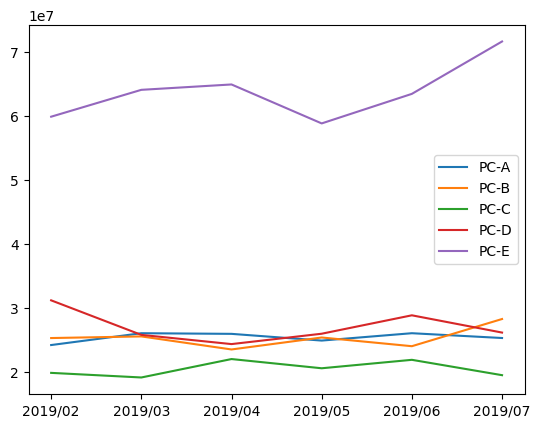

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(graph_data["payment_month"], graph_data["PC-A"], label = "PC-A")
plt.plot(graph_data["payment_month"], graph_data["PC-B"], label = "PC-B")
plt.plot(graph_data["payment_month"], graph_data["PC-C"], label = "PC-C")
plt.plot(graph_data["payment_month"], graph_data["PC-D"], label = "PC-D")
plt.plot(graph_data["payment_month"], graph_data["PC-E"], label = "PC-E")
plt.legend()